# Code

## Imports and packages required

In [1]:
import numpy as np
import pandas as pd

## Preprocessing

### 1. Reading the CSV File

In [2]:
df = pd.read_csv('../data/online_retail_listing.csv', on_bad_lines='skip',delimiter=';', decimal = ',')
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,6.75,13085.0,United Kingdom


### 2. InvoiceDate column type conversion from String to DateTime

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = "%d.%m.%Y %H:%M")

### 3. Customer ID column type conversion from Float to Int

In [4]:
df['Customer ID'] = df['Customer ID'].astype('Int64')

### 4. Quantity and price - Filter out bad values

In [5]:
df = df[df['Quantity']>=0]
df = df[df['Price']>=0]

### 5. Processing the Description

1. Convert all descriptions to uppercase
2. Find `StockCode`s with multiple descriptions (Lengthy, Short, NaN, etc.) and keep the longest string as the detailed description
3. Filter out transactions with no descriptions (66 found)
4. Strip the string to remove any leading and trailing whitespaces

In [6]:
#1
df["Description"] = df["Description"].str.upper()

#2
grps = df[["StockCode", "Description"]].drop_duplicates().groupby("StockCode")
desc_replacer = dict()
for grp in grps:
    if len(grp[1])>1:
        desc_replacer[grp[0]] = grp[1]["Description"][grp[1]["Description"].map(str).agg(len).idxmax()]

df["Description"] = df.apply(
        axis=1, 
        func=lambda x: desc_replacer[x["StockCode"]] if x["StockCode"] in desc_replacer.keys() else x["Description"]
    )

#3
df = df[df['Description'].notna()]

#4
df["Description"] = df["Description"].map(lambda x: str(x).strip())

### 6. Processing the Customer IDs

In the dataset, we know that there is no such entry where the same invoice is shared between two customers.

Let us check if the same invoice has a customer ID in some entries, and NA in other

In [7]:
df["Customer ID"].isna().sum()

232427

In [8]:
empty_CID_Orders = df[df["Customer ID"].isna()]["Invoice"].drop_duplicates().values.tolist()
display(df[df["Invoice"].map(lambda x: x in empty_CID_Orders)]["Customer ID"].notna().sum())

0

Since there are no invoices where we can recover `Customer ID` from another entry, we can give placeholder IDs to Customers with ID `NA`, assuming each invoice corresponds to a new customer.

In [9]:
max_existing_id = df["Customer ID"].max()
invoice_cust_dict = dict()

for key in empty_CID_Orders:
    max_existing_id += 1
    invoice_cust_dict[key] = max_existing_id

df["Valid_Customer"] = df["Customer ID"].notna().map(lambda x: int(x))
df["Customer ID"] = df.apply(
        axis=1, 
        func=lambda x: invoice_cust_dict[x["Invoice"]] if x["Invoice"] in invoice_cust_dict.keys() else x["Customer ID"]
    )

### 7. Removing Cancelled transactions

In [14]:
df = df[df["Invoice"].map(lambda x: "c" not in str(x).lower())]

### 8. Drop duplicate entries of the same transaction

In [15]:
df.drop_duplicates(inplace=True)

### 9. Check for invalid data in the DataFrame

In [16]:
df.isna().sum()

Invoice           0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
Price             0
Customer ID       0
Country           0
Valid_Customer    0
dtype: int64

### 10. Save the cleaned DataFrame for further analysis

In [17]:
df.to_csv('../data/online_retail_listing_cleaned.csv', index=False)

## Exploratory Data Analysis

In [ ]:
#!pip install pandas-profiling

In [ ]:
import pandas_profiling
#Generating PandasProfiling Report
report = pandas_profiling.ProfileReport(df)

In [ ]:
report

In [ ]:
df.drop_duplicates()

In [ ]:
# skewness along the index axis
df.skew(axis = 0, skipna = True)# highly skewed price, indicating there might be a few low priced items 

In [ ]:
df['Country'].unique()


## Market basket Analysis

#### Complementary Products

In [2]:
df_mba = pd.read_csv("../data/online_retail_listing_cleaned.csv")
df_mba['InvoiceDate'] = pd.to_datetime(df_mba['InvoiceDate'], format = "%Y-%m-%d %H:%M:%S")
df_mba.head()

C:\Users\chyav\AppData\Local\Temp\ipykernel_16684\3878480219.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mba = pd.read_csv("../data/online_retail_listing_cleaned.csv")


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Valid_Customer
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,1


In [3]:
mba = df_mba[["Invoice", "StockCode"]]
unique_items = mba["StockCode"].drop_duplicates()

In [4]:
mba_unique = mba.drop_duplicates()
mba_crosstab = pd.crosstab(mba_unique["Invoice"], mba_unique["StockCode"])

product_counts = unique_items.map(lambda product: mba_crosstab[[product]].value_counts().get(1, 0))
product_counts.index = unique_items.values

N = len(mba_crosstab)

In [5]:
def calculate_lift(product_1, product_2):
    count_1 = product_counts[product_1]
    count_2 = product_counts[product_2]
    count_12 = mba_crosstab[[product_1, product_2]].value_counts().get((1,1), 0)
    if count_12 == 0:
        return 0
    return N*count_12/(count_1*count_2)

calculate_lift("85048", "23562")

3.9035336356764927

In [201]:
# 1.  Load Lift Matrix
try:
    lifts = pd.read_csv("../data/lifts.csv", index_col="idx")
    lifts.index.name = None

# 2. Create Lift Matrix
except FileNotFoundError: 
    lifts = pd.DataFrame([], columns=unique_items.values, index=unique_items.values)
    lifts["processed"] = False

lifts.head()

,85048,79323P,79323W,22041,21232,22064,21871,21523,22350,22349,...,23578,23580,23575,23560,23576,23562,23561,23609,23617,processed
85048,NaN,3.09,2.82,2.40,2.24,3.27,3.62,2.06,3.21,2.24,...,0.00,5.46,11.71,10.25,5.86,3.90,0.00,81.97,81.97,True
79323P,3.09,NaN,72.82,1.43,3.10,7.14,6.28,5.47,4.70,3.83,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,True
79323W,2.82,72.82,NaN,1.30,2.89,3.85,4.62,5.00,4.64,3.88,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,True
22041,2.40,1.43,1.30,NaN,3.88,4.47,4.72,2.79,3.19,2.27,...,0.00,10.09,10.81,0.00,10.81,3.60,12.61,0.00,75.67,True
21232,2.24,3.10,2.89,3.88,NaN,10.86,4.00,2.83,3.14,2.24,...,2.14,2.28,3.66,2.14,2.44,1.63,2.85,17.09,17.09,True


In [202]:
import datetime

start = datetime.datetime.now()

for i, item1 in enumerate(unique_items.values):
    if lifts.iloc[i]["processed"]:
        continue
    for j, item2 in enumerate(unique_items.values):
        if i > j:
            lift = calculate_lift(item1, item2)
            lifts.loc[item1, item2] = lift
            lifts.loc[item2, item1] = lift
    lifts.loc[item1, "processed"] = True
    lifts.round(2).to_csv("../data/lifts.csv", index_label="idx")
    end = datetime.datetime.now()
    if (end - start).seconds > 3600:
        break

# Takes 24 hours to execute

In [217]:
top_n = 5
col_names = dict([(x, f"Top-{x+1} Match") for x in range(top_n)])

In [218]:
top_n_complementary = lifts.apply(lambda x: x.sort_values(ascending=False)[:top_n].index).drop(columns=["processed"])
products = df_mba[["StockCode", "Description"]].drop_duplicates().set_index("StockCode")["Description"]

In [219]:
top_n_complementary.columns = list(map(lambda x: products[x], top_n_complementary.columns.values))
top_n_complementary = top_n_complementary.apply(lambda s: s.map(lambda x: products[x])).T \
    .rename(columns=col_names)
top_n_complementary.head()

,Top-1 Match,Top-2 Match,Top-3 Match,Top-4 Match,Top-5 Match
15CM CHRISTMAS GLASS BALL 20 LIGHTS,SET 10 CARDS SWIRLY XMAS TREE 17104,ROMANTIC PINKS RIBBONS,ROSE 3 WICK MORRIS BOX CANDLE,BLACK BAROQUE CUCKOO CLOCK,*USB OFFICE GLITTER LAMP
PINK CHERRY LIGHTS,HANDZ-OFF CAR FRESHENER,PINK BALLET OPENING CUBE BOX,"ACRYLIC JEWEL ICICLE, CLEAR",DR WHO TOP TRUMPS GAME,EURO FOOTBALL STARS TOP TRUMPS GAME
WHITE CHERRY LIGHTS,*USB OFFICE GLITTER LAMP,DR WHO TOP TRUMPS GAME,HANDZ-OFF CAR FRESHENER,AMBER VINTAGE EARRINGS,EURO FOOTBALL STARS TOP TRUMPS GAME
"RECORD FRAME 7"" SINGLE SIZE",SET 10 CARDS SWIRLY XMAS TREE 17104,SET 10 CARDS DECK THE HALLS 16960,*BOOMBOX IPOD CLASSIC,IVORY PENDANT SHELL NECKLACE,"LETTER ""U"" BLING KEY RING"
STRAWBERRY CERAMIC TRINKET BOX,SET 10 CARDS SWIRLY XMAS TREE 17104,ROSE PINK PENDANT SHELL NECKLACE,VINTAGE METAL CAKE STAND CREAM,LARGE WHITE CHOCOLATE CANDLE,SET OF 2 CHESTS CHOCOLAT AU LAIT


In [220]:
top_n_complementary.to_csv("../data/top_n_complementary.csv", index_label="Product")

#### Substitutive Products

In [221]:
top_n_complementary = lifts.apply(lambda x: x.sort_values(ascending=False)[:top_n].index).drop(columns=["processed"])
top_n_substitutive = top_n_complementary.apply(lambda series:
    pd.Series(
        pd.Series(
            series \
                .map(lambda x: [x for x in top_n_complementary[x].tolist() if x != series.name]) \
                .sum()
                ) \
            .value_counts()[:top_n] \
            .index \
            .values
        )
)

In [222]:
top_n_substitutive.columns = list(map(lambda x: products[x], top_n_substitutive.columns.values))
top_n_substitutive = top_n_substitutive.apply(lambda s: s.map(lambda x: products[x])).T \
    .rename(columns=col_names)
top_n_substitutive.head()

,Top-1 Match,Top-2 Match,Top-3 Match,Top-4 Match,Top-5 Match
15CM CHRISTMAS GLASS BALL 20 LIGHTS,SET 10 CARDS JINGLE BELLS 17217,CHARLIE + LOLA BISCUITS TINS,KNITTED RAINBOW HOT WATER BOTTLE,ENGLISH ROSE EDWARDIAN PARASOL,DOGS NIGHT COLLAR
PINK CHERRY LIGHTS,PACK/12 RUSSIAN DOLL CARDS,ORIGAMI ROSE INCENSE+FLOWER,BLACK DIAMOND CLUSTER EARRINGS,NATURAL RIVIERA HANDBAG,PASTEL BLUE PHOTO ALBUM
WHITE CHERRY LIGHTS,VINTAGE SILVER TINSEL REEL,ENGLISH ROSE EDWARDIAN PARASOL,ASSORTED FRUIT STRAWS,PACK/12 RUSSIAN DOLL CARDS,NATURAL RIVIERA HANDBAG
"RECORD FRAME 7"" SINGLE SIZE",SET 10 CARDS JINGLE BELLS 17217,AMBER GLASS/SHELL/PEARL NECKLACE,"LETTER ""Z"" BLING KEY RING","LETTER ""O"" BLING KEY RING","LETTER ""Y"" BLING KEY RING"
STRAWBERRY CERAMIC TRINKET BOX,BLUE/WHITE RIBBED MELAMINE JUG,SET 10 CARDS JINGLE BELLS 17217,PURPLE ANEMONE ARTIFICIAL FLOWER,72 ROUND PINK DOILIES,WHITE CERAMIC PARTY SET (5PCS)


In [223]:
top_n_substitutive.to_csv("../data/top_n_substitutive.csv", index_label="Product")

# Customer Segmentation

## RFM Analysis

In [24]:
#To calculate the recency we set current date after the msot recent purchase in the dataset
df['InvoiceDate'].max()

Timestamp('2011-12-04 13:15:00')

In [25]:
PRESENT = dt.datetime(2011,12,31)

In [26]:
#For each Customer ID, we calcualte the date last purchased, how many times they purchased and the toal money spent
df2= df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'Invoice': lambda num: len(num),
                                        'Price': lambda price: price.sum(), 'StockCode': lambda stock: list(stock)})
df2

,InvoiceDate,Invoice,Price,StockCode
Customer ID,,,,
12346,346,34,207.40,"[TEST001, TEST001, TEST001, TEST001, TEST002, ..."
12347,60,211,541.03,"[22698, 22699, 20985, 22418, 22422, 51014A, 51..."
12348,96,51,193.10,"[21213, 84991, 22951, 84992, 21977, 84988, 849..."
12349,39,175,1480.44,"[22554, 22555, 22553, 16156S, 22052, 22048, 22..."
12350,331,17,65.30,"[21908, 22412, 79066K, 79191C, 22348, 84086C, ..."
...,...,...,...,...
23134,28,650,3459.21,"[15036, 15044A, 15056N, 16168M, 16219, 16225, ..."
23135,28,12,41.48,"[23312, 23349, 23351, 23580, 23527, 21976, 234..."
23136,28,1,0.00,[22606]


In [27]:
df2.columns=['recency','frequency','monetary','stock_code']
df2.describe()

,recency,frequency,monetary
count,10713.000000,10713.000000,10713.000000
mean,310.664333,92.607766,376.009026
std,228.822816,260.139353,1099.191603
min,26.000000,1.000000,0.000000
25%,81.000000,2.000000,8.870000
50%,281.000000,26.000000,97.710000
75%,498.000000,99.000000,385.230000
max,759.000000,12121.000000,55966.880000


In [29]:
#We bin customers into 125 profiles
df2['r_quartile'] = pd.qcut(df2['recency'].rank(method='first'),5,['1','2','3','4','5'])
df2['f_quartile'] = pd.qcut(df2['frequency'].rank(method='first'), 5,['1','2','3','4','5'])
df2['m_quartile'] = pd.qcut(df2['monetary'].rank(method='first'), 5,['1','2','3','4','5'])
df2

,recency,frequency,monetary,stock_code,r_quartile,f_quartile,m_quartile
Customer ID,,,,,,,
12346,346,34,207.40,"[TEST001, TEST001, TEST001, TEST001, TEST002, ...",3,3,4
12347,60,211,541.03,"[22698, 22699, 20985, 22418, 22422, 51014A, 51...",1,5,5
12348,96,51,193.10,"[21213, 84991, 22951, 84992, 21977, 84988, 849...",2,4,4
12349,39,175,1480.44,"[22554, 22555, 22553, 16156S, 22052, 22048, 22...",1,5,5
12350,331,17,65.30,"[21908, 22412, 79066K, 79191C, 22348, 84086C, ...",3,3,3
...,...,...,...,...,...,...,...
23134,28,650,3459.21,"[15036, 15044A, 15056N, 16168M, 16219, 16225, ...",1,5,5
23135,28,12,41.48,"[23312, 23349, 23351, 23580, 23527, 21976, 234...",1,2,2
23136,28,1,0.00,[22606],1,2,1


In [47]:
#Calculating the rfm segment string
df2['rfm_segment'] = df2.r_quartile.astype(str)+ df2.f_quartile.astype(str) + df2.m_quartile.astype(str)
#df2['rfm_segment'] = df2.r_quartile*100 + df2.f_quartile*10 + df2.m_quartile
df2.head()

,recency,frequency,monetary,stock_code,r_quartile,f_quartile,m_quartile,rfm_segment
Customer ID,,,,,,,,
12346,346,34,207.40,"[TEST001, TEST001, TEST001, TEST001, TEST002, ...",3,3,4,334
12347,60,211,541.03,"[22698, 22699, 20985, 22418, 22422, 51014A, 51...",1,5,5,155
12348,96,51,193.10,"[21213, 84991, 22951, 84992, 21977, 84988, 849...",2,4,4,244
12349,39,175,1480.44,"[22554, 22555, 22553, 16156S, 22052, 22048, 22...",1,5,5,155
12350,331,17,65.30,"[21908, 22412, 79066K, 79191C, 22348, 84086C, ...",3,3,3,333


In [48]:
#The rfm segments with only one customer
df2['rfm_segment'].drop_duplicates(keep=False)
#len(df2) is 11 they maybe the outliers

Customer ID
13687    442
13810    135
15222    353
16943    335
17750    153
18079    253
19347    531
21638    314
Name: rfm_segment, dtype: object

In [49]:
#To find the most frequently purchased item in each segment
df3=df2
df4=df3.explode('stock_code')
df4=df4[df4.stock_code!='TEST001'] 
df4=df4[df4.stock_code!='TEST002'] 
df4

,recency,frequency,monetary,stock_code,r_quartile,f_quartile,m_quartile,rfm_segment
Customer ID,,,,,,,,
12346,346,34,207.40,20682,3,3,4,334
12346,346,34,207.40,20679,3,3,4,334
12346,346,34,207.40,15056N,3,3,4,334
12346,346,34,207.40,15056BL,3,3,4,334
12346,346,34,207.40,15056P,3,3,4,334
...,...,...,...,...,...,...,...,...
23135,28,12,41.48,22730,1,2,2,122
23135,28,12,41.48,23479,1,2,2,122
23136,28,1,0.00,22606,1,2,1,121


In [55]:
# Optional to profile customers based on rfm score
df4['rfm_segment'] = df4['rfm_segment'].astype(int)
df4["Customer_segment"] = np.where(df4['rfm_segment'] <
                                      222, "Top Customers",
                                      (np.where(
                                        df4['rfm_segment'] < 333,
                                        "High value Customer",
                                        (np.where(
    df4['rfm_segment'] < 444,
                             "Medium Value Customer",
                             np.where(df4['rfm_segment'] < 555,
                            'Low Value Customers', 'Lost Customers'))))))
df4

,recency,frequency,monetary,stock_code,r_quartile,f_quartile,m_quartile,rfm_segment,Customer_segment
Customer ID,,,,,,,,,
12346,346,34,207.40,20682,3,3,4,334,Medium Value Customer
12346,346,34,207.40,20679,3,3,4,334,Medium Value Customer
12346,346,34,207.40,15056N,3,3,4,334,Medium Value Customer
12346,346,34,207.40,15056BL,3,3,4,334,Medium Value Customer
12346,346,34,207.40,15056P,3,3,4,334,Medium Value Customer
...,...,...,...,...,...,...,...,...,...
23135,28,12,41.48,22730,1,2,2,122,Top Customers
23135,28,12,41.48,23479,1,2,2,122,Top Customers
23136,28,1,0.00,22606,1,2,1,121,Top Customers


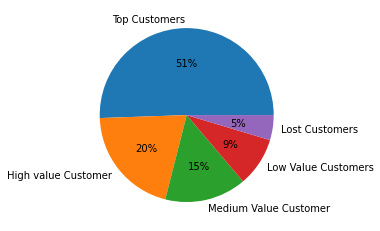

In [58]:
from matplotlib import pyplot as plt
plt.pie(df4.Customer_segment.value_counts(),
        labels=df4.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [56]:
#The most purchased item in each rfm segment
df5 = df4.groupby('rfm_segment')['stock_code'].agg(pd.Series.mode)
df5

rfm_segment
111    [15036, 22993, 84826, 85099B]
112                   [22112, 23328]
121                            16014
122                            22086
123                            23355
                   ...              
543                            21034
544                           85123A
545                              DOT
554           [20914, 22058, 85123A]
555                              DOT
Name: stock_code, Length: 97, dtype: object